In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=150)

# Import raw files

In [2]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [3]:
adataMGH102 = sc.read(inpath+"MGH102.h5ad")
adataMGH105 = sc.read(inpath+"MGH105.h5ad")
adataMGH115 = sc.read(inpath+"MGH115.h5ad")
adataMGH124 = sc.read(inpath+"MGH124.h5ad")
adataMGH125 = sc.read(inpath+"MGH125.h5ad")
adataMGH126 = sc.read(inpath+"MGH126.h5ad")

In [4]:
adataMGH105.obs['Sample'] = "Patient8"
adataMGH115.obs['Sample'] = "Patient9"
adataMGH126.obs['Sample'] = "Patient12"

# Read Metadata

In [5]:
metadata = pd.read_excel('Metadata2.xlsx')

# Fix Metadata 

In [6]:
tmp1 = metadata.loc[metadata['SampleID'] == "MGH102"].loc[metadata.loc[metadata['SampleID'] == "MGH102"].index.repeat(adataMGH102.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "MGH102-" + tmp1.index.astype(str),inplace=True) 
adataMGH102.obs = tmp1

In [7]:
tmp1 = metadata.loc[metadata['SampleID'] == "MGH105"].loc[metadata.loc[metadata['SampleID'] == "MGH105"].index.repeat(adataMGH105.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "MGH105-" + tmp1.index.astype(str),inplace=True) 
adataMGH105.obs = tmp1

In [8]:
tmp1 = metadata.loc[metadata['SampleID'] == "MGH115"].loc[metadata.loc[metadata['SampleID'] == "MGH115"].index.repeat(adataMGH115.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "MGH115-" + tmp1.index.astype(str),inplace=True) 
adataMGH115.obs = tmp1

In [9]:
tmp1 = metadata.loc[metadata['SampleID'] == "MGH124"].loc[metadata.loc[metadata['SampleID'] == "MGH124"].index.repeat(adataMGH124.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "MGH124-" + tmp1.index.astype(str),inplace=True) 
adataMGH124.obs = tmp1

In [10]:
tmp1 = metadata.loc[metadata['SampleID'] == "MGH125"].loc[metadata.loc[metadata['SampleID'] == "MGH125"].index.repeat(adataMGH125.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "MGH125-" + tmp1.index.astype(str),inplace=True) 
adataMGH125.obs = tmp1

In [11]:
tmp1 = metadata.loc[metadata['SampleID'] == "MGH126"].loc[metadata.loc[metadata['SampleID'] == "MGH126"].index.repeat(adataMGH126.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "MGH126-" + tmp1.index.astype(str),inplace=True) 
adataMGH126.obs = tmp1

# Concatenate 

In [12]:
adataMGH102.var_names_make_unique()
adataMGH105.var_names_make_unique()
adataMGH115.var_names_make_unique()
adataMGH124.var_names_make_unique()
adataMGH125.var_names_make_unique()
adataMGH126.var_names_make_unique()

In [13]:
adata = adataMGH102.concatenate(adataMGH105,adataMGH115,adataMGH124,adataMGH125,adataMGH126,index_unique=None)

In [14]:
del(adataMGH102, adataMGH105,adataMGH115,adataMGH124,adataMGH125,adataMGH126)

In [15]:
print(adata.obs['SampleID'].value_counts())
adata

MGH105    5513
MGH124    2415
MGH102    1822
MGH125    1613
MGH115    1283
MGH126     229
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 12875 × 30314
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'

In [16]:
#adata.layers['raw'] = adata.X 

# Calculate QC

In [17]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [18]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [19]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

# Plot QC

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


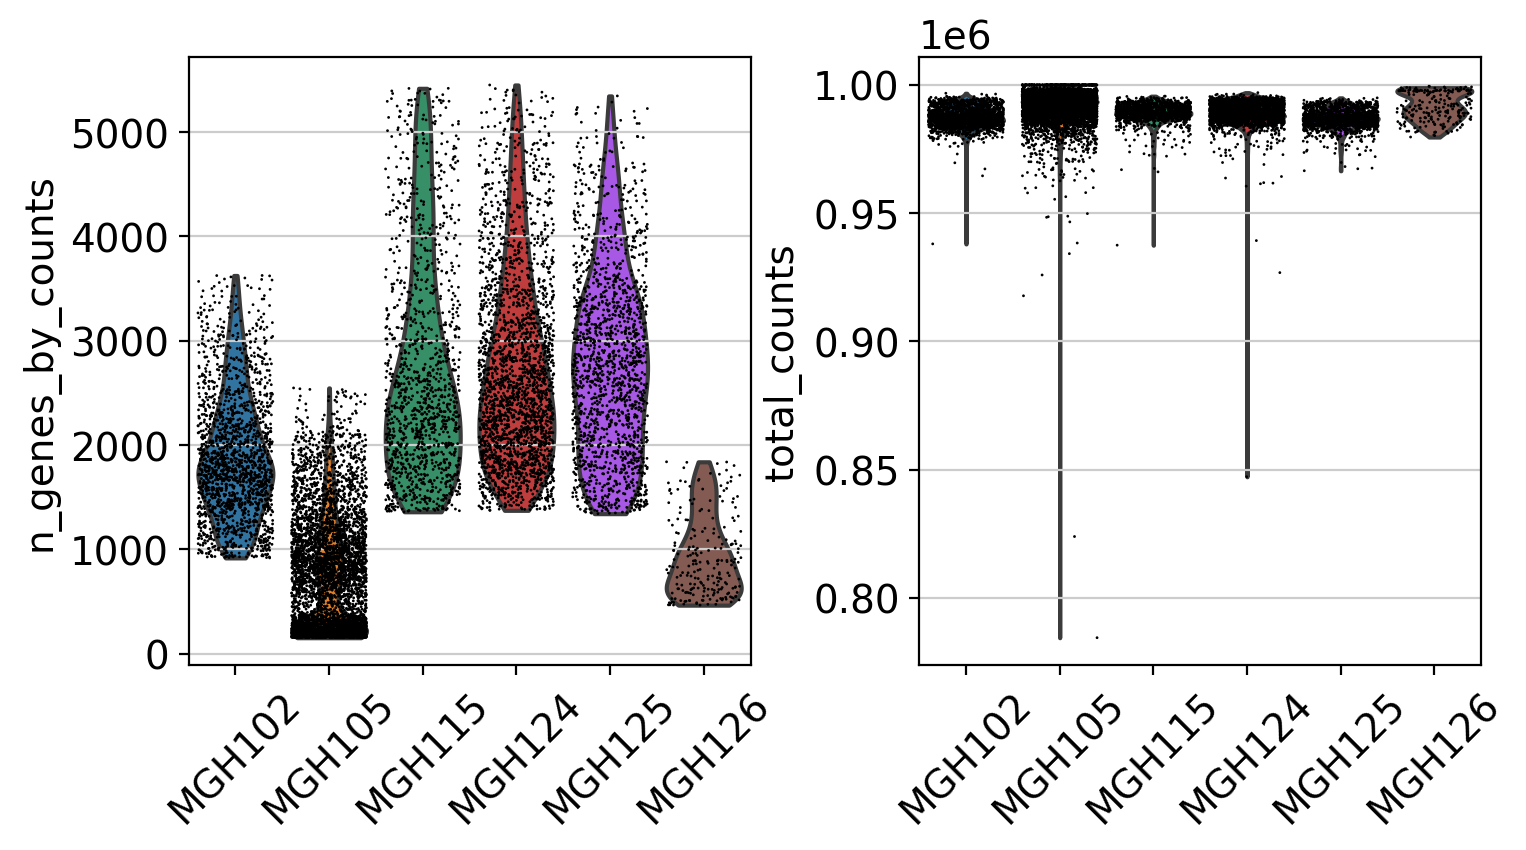

In [20]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

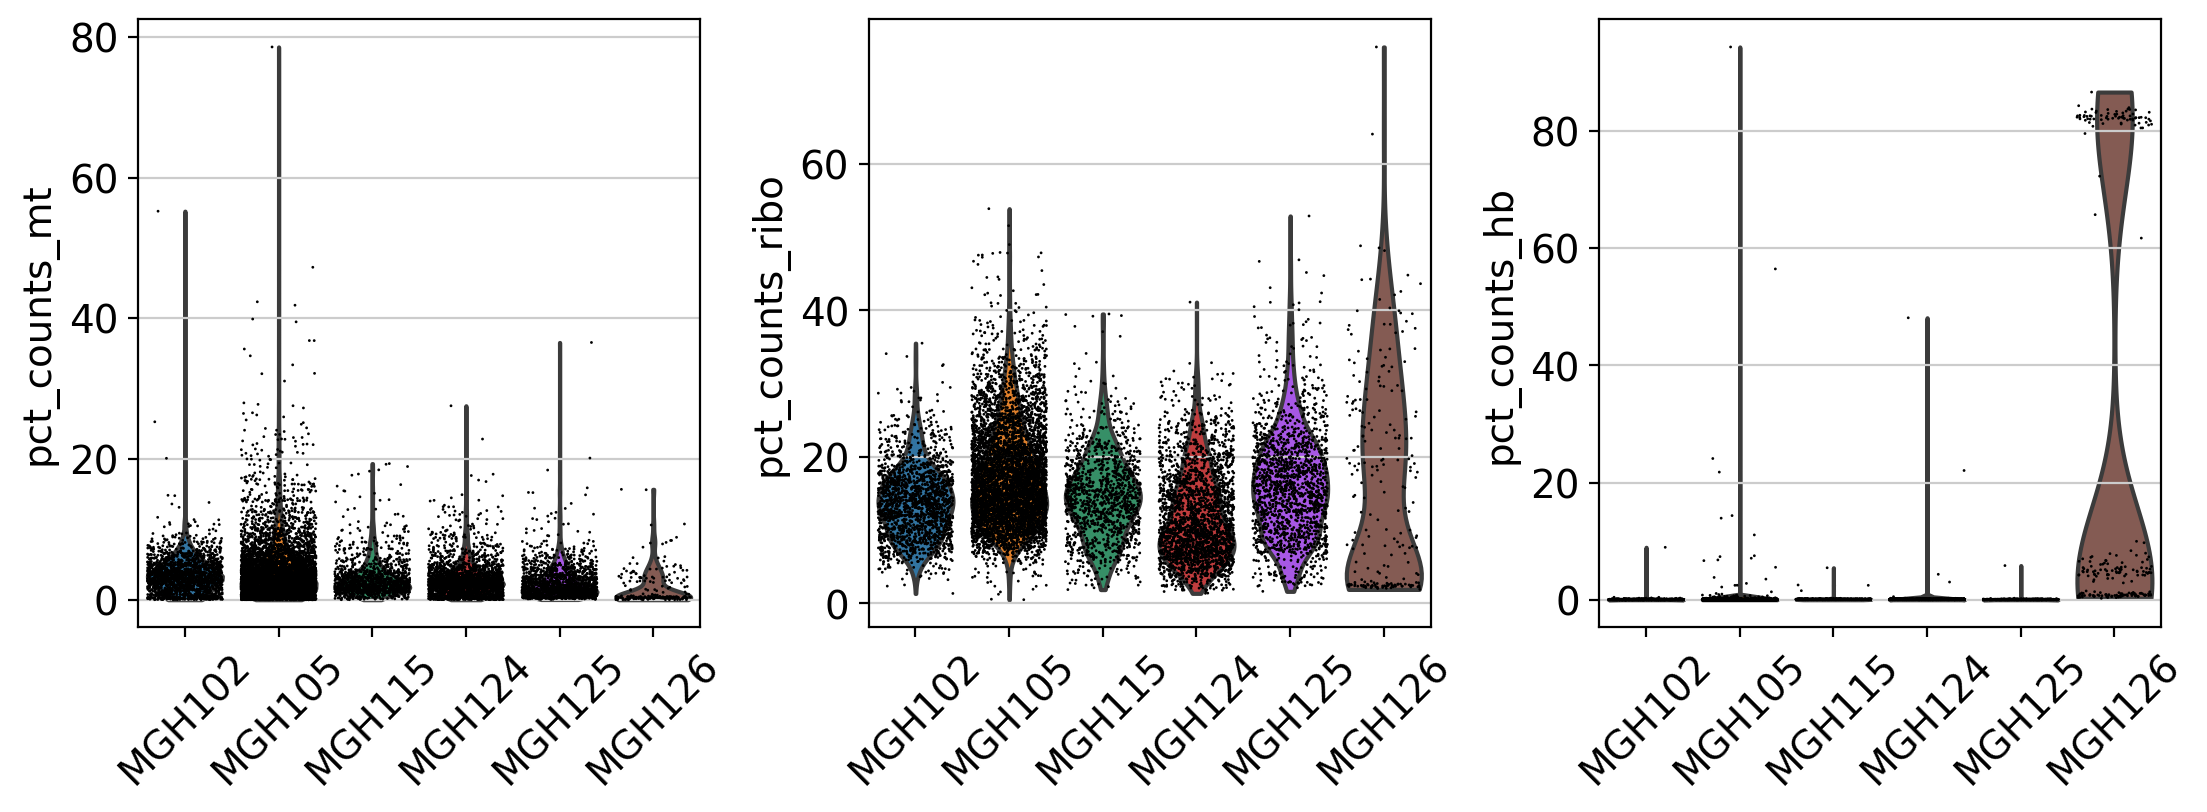

In [21]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

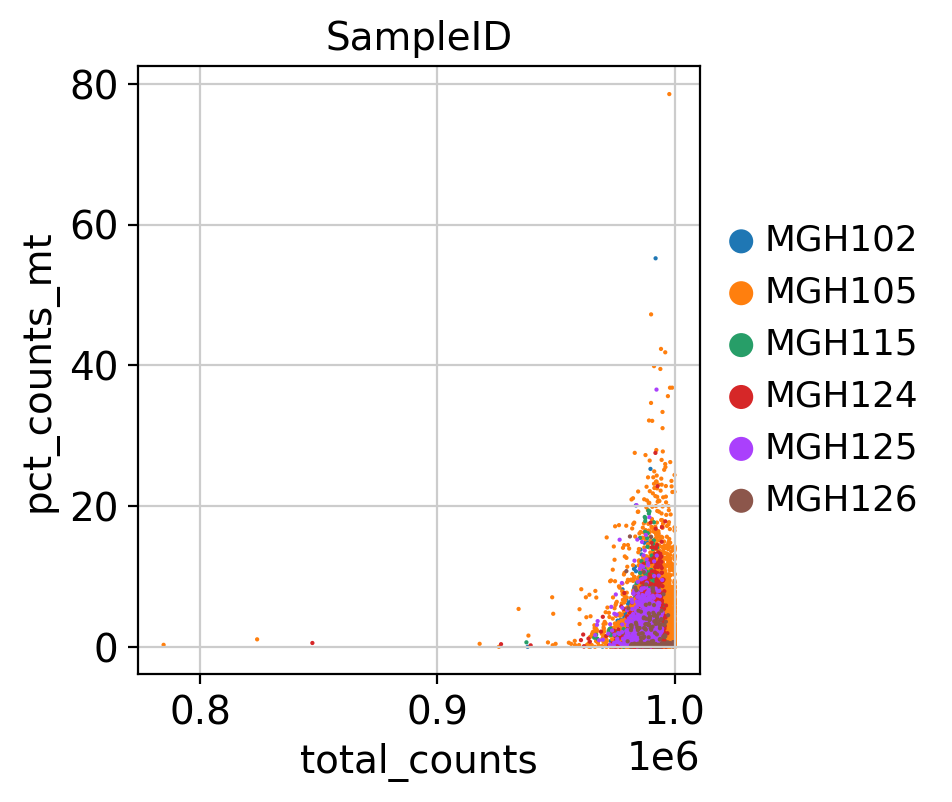

In [22]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [23]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

11786 21472


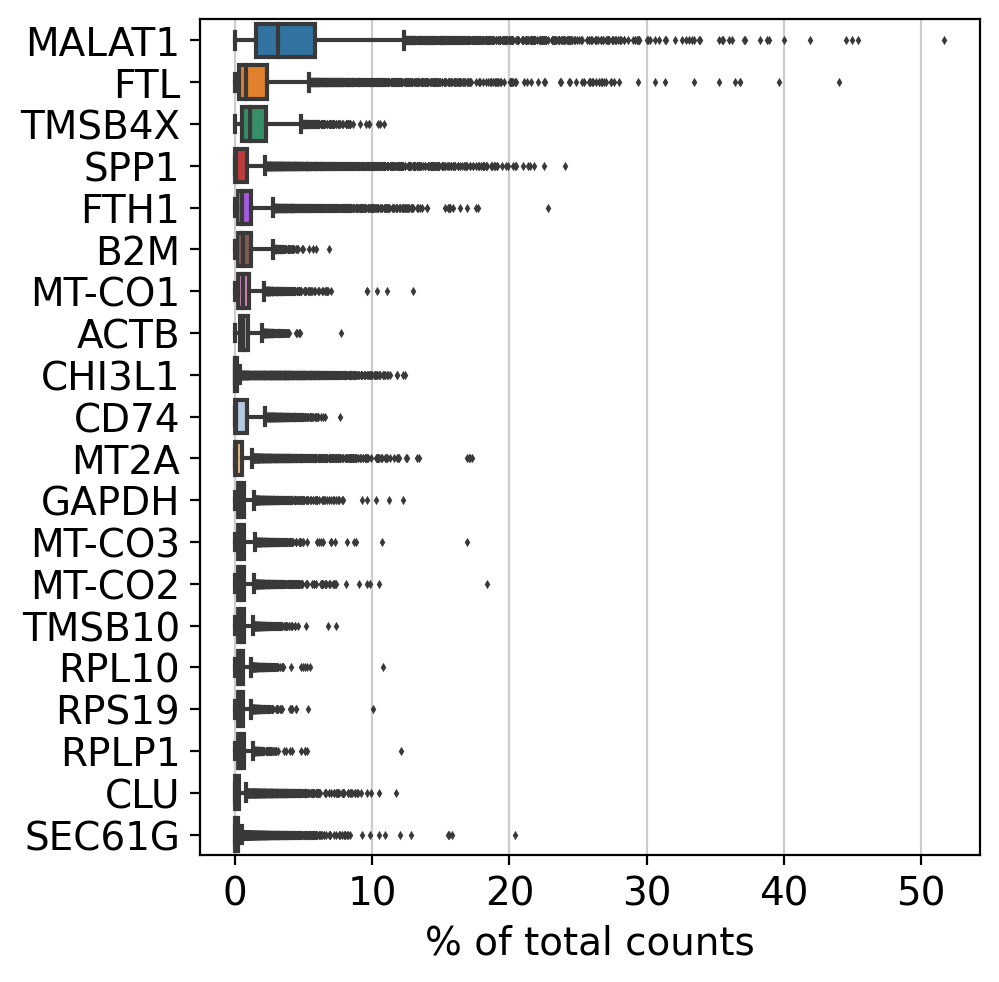

In [24]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Filter genes

In [26]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [27]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [28]:
adata = adata[:, ~mito_gene_indicator]

In [ ]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

# Processing 

In [29]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata

# scale
#sc.pp.scale(adata)

# Celltypist classification

In [30]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [31]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [32]:
sce.pp.harmony_integrate(adata, ['SampleID'])

2022-06-13 17:18:17,406 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-13 17:18:19,113 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-13 17:18:20,823 - harmonypy - INFO - Converged after 2 iterations
Converged after 2 iterations


In [33]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [34]:
sc.tl.umap(adata)

In [35]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [37]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

# PanglaoDB classification

In [45]:
markers = dc.get_resource('PanglaoDB')
markers

label,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.0,0.00439422,True,0.00331126,0.0204803,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.00503937,True,0.903226,0.0124084,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.0,0.00823306,True,0.225806,0.0137585,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8473,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8474,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8475,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


In [46]:
markers['organ'].value_counts()

Immune system         1775
Brain                 1589
GI tract               540
Kidney                 450
Reproductive           429
Connective tissue      413
Vasculature            372
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        168
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                28
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: organ, dtype: int64

In [47]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
5,KLK1,True,Principal cells,Mesoderm,True,0.0,0.00814536,True,0.285714,0.0140583,9606,Kidney,0.013
7,KLK1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.0,0.00820189,True,1.0,0.0129136,9606,Immune system,0.013
8,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8473,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8474,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8475,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


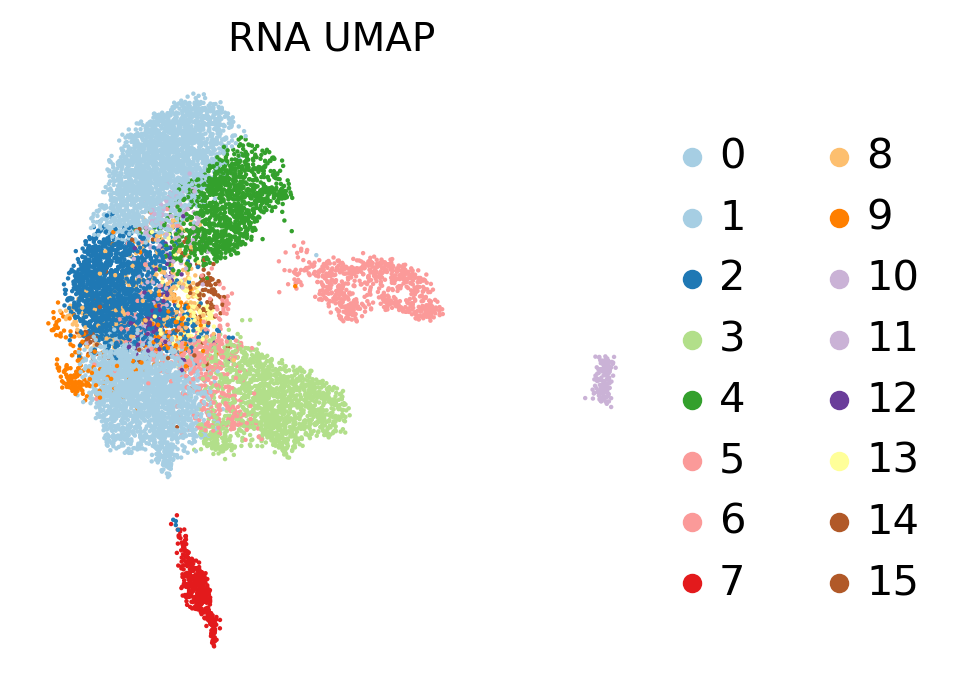

In [48]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [49]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 11786 samples and 21459 targets for 148 sources.


100%|██████████| 11786/11786 [00:13<00:00, 902.93it/s]


In [50]:
adata.obsm['ora_estimate']

source,Acinar cells,Adipocyte progenitor cells,Adipocytes,Adrenergic neurons,Airway goblet cells,Alpha cells,Alveolar macrophages,Anterior pituitary gland cells,Astrocytes,B cells,...,T regulatory cells,Tanycytes,Taste receptor cells,Thymocytes,Trichocytes,Trigeminal neurons,Trophoblast cells,Trophoblast progenitor cells,Tuft cells,Urothelial cells
MGH102-0,0.081456,0.447636,0.015565,-0.0,-0.0,-0.000000,-0.000000,-0.000000,0.641144,-0.000000,...,-0.00000,0.505928,0.249621,-0.000000,-0.0,-0.0,-0.000000,-0.000000,0.125938,-0.0
MGH102-1,-0.000000,-0.000000,0.406975,-0.0,-0.0,0.076668,-0.000000,-0.000000,0.381613,-0.000000,...,-0.00000,0.505928,-0.000000,-0.000000,-0.0,-0.0,0.703438,-0.000000,-0.000000,-0.0
MGH102-2,-0.000000,0.447636,0.242247,-0.0,-0.0,-0.000000,-0.000000,-0.000000,0.192082,-0.000000,...,-0.00000,0.163630,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000,0.125938,-0.0
MGH102-3,0.081456,-0.000000,0.620141,-0.0,-0.0,0.076668,-0.000000,-0.000000,0.641144,-0.000000,...,0.29088,1.624627,0.249621,0.478842,-0.0,-0.0,0.703438,-0.000000,-0.000000,-0.0
MGH102-4,-0.000000,-0.000000,0.052428,-0.0,-0.0,0.076668,-0.000000,-0.000000,0.192082,-0.000000,...,0.29088,0.163630,-0.000000,0.153086,-0.0,-0.0,-0.000000,-0.000000,0.125938,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGH126-224,-0.000000,-0.000000,0.406975,-0.0,-0.0,0.271725,-0.000000,0.617998,0.641144,0.902043,...,-0.00000,0.505928,-0.000000,0.478842,-0.0,-0.0,-0.000000,-0.000000,0.125938,-0.0
MGH126-225,0.081456,-0.000000,0.406975,-0.0,-0.0,1.006957,1.588390,-0.000000,0.192082,3.278135,...,0.29088,0.505928,-0.000000,0.953915,-0.0,-0.0,0.703438,0.816797,0.829817,-0.0
MGH126-226,0.610886,-0.000000,0.015565,-0.0,-0.0,0.271725,-0.000000,-0.000000,1.355607,1.379348,...,-0.00000,0.505928,-0.000000,1.555812,-0.0,-0.0,-0.000000,-0.000000,0.125938,-0.0
MGH126-227,0.285486,-0.000000,1.536261,-0.0,-0.0,-0.000000,0.617998,-0.000000,0.967277,0.234684,...,0.29088,0.505928,-0.000000,0.478842,-0.0,-0.0,-0.000000,-0.000000,0.125938,-0.0


In [51]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 11786 × 148
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'leiden', 'majority_voting'
    uns: 'SampleID_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [2]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

NameError: name 'dc' is not defined

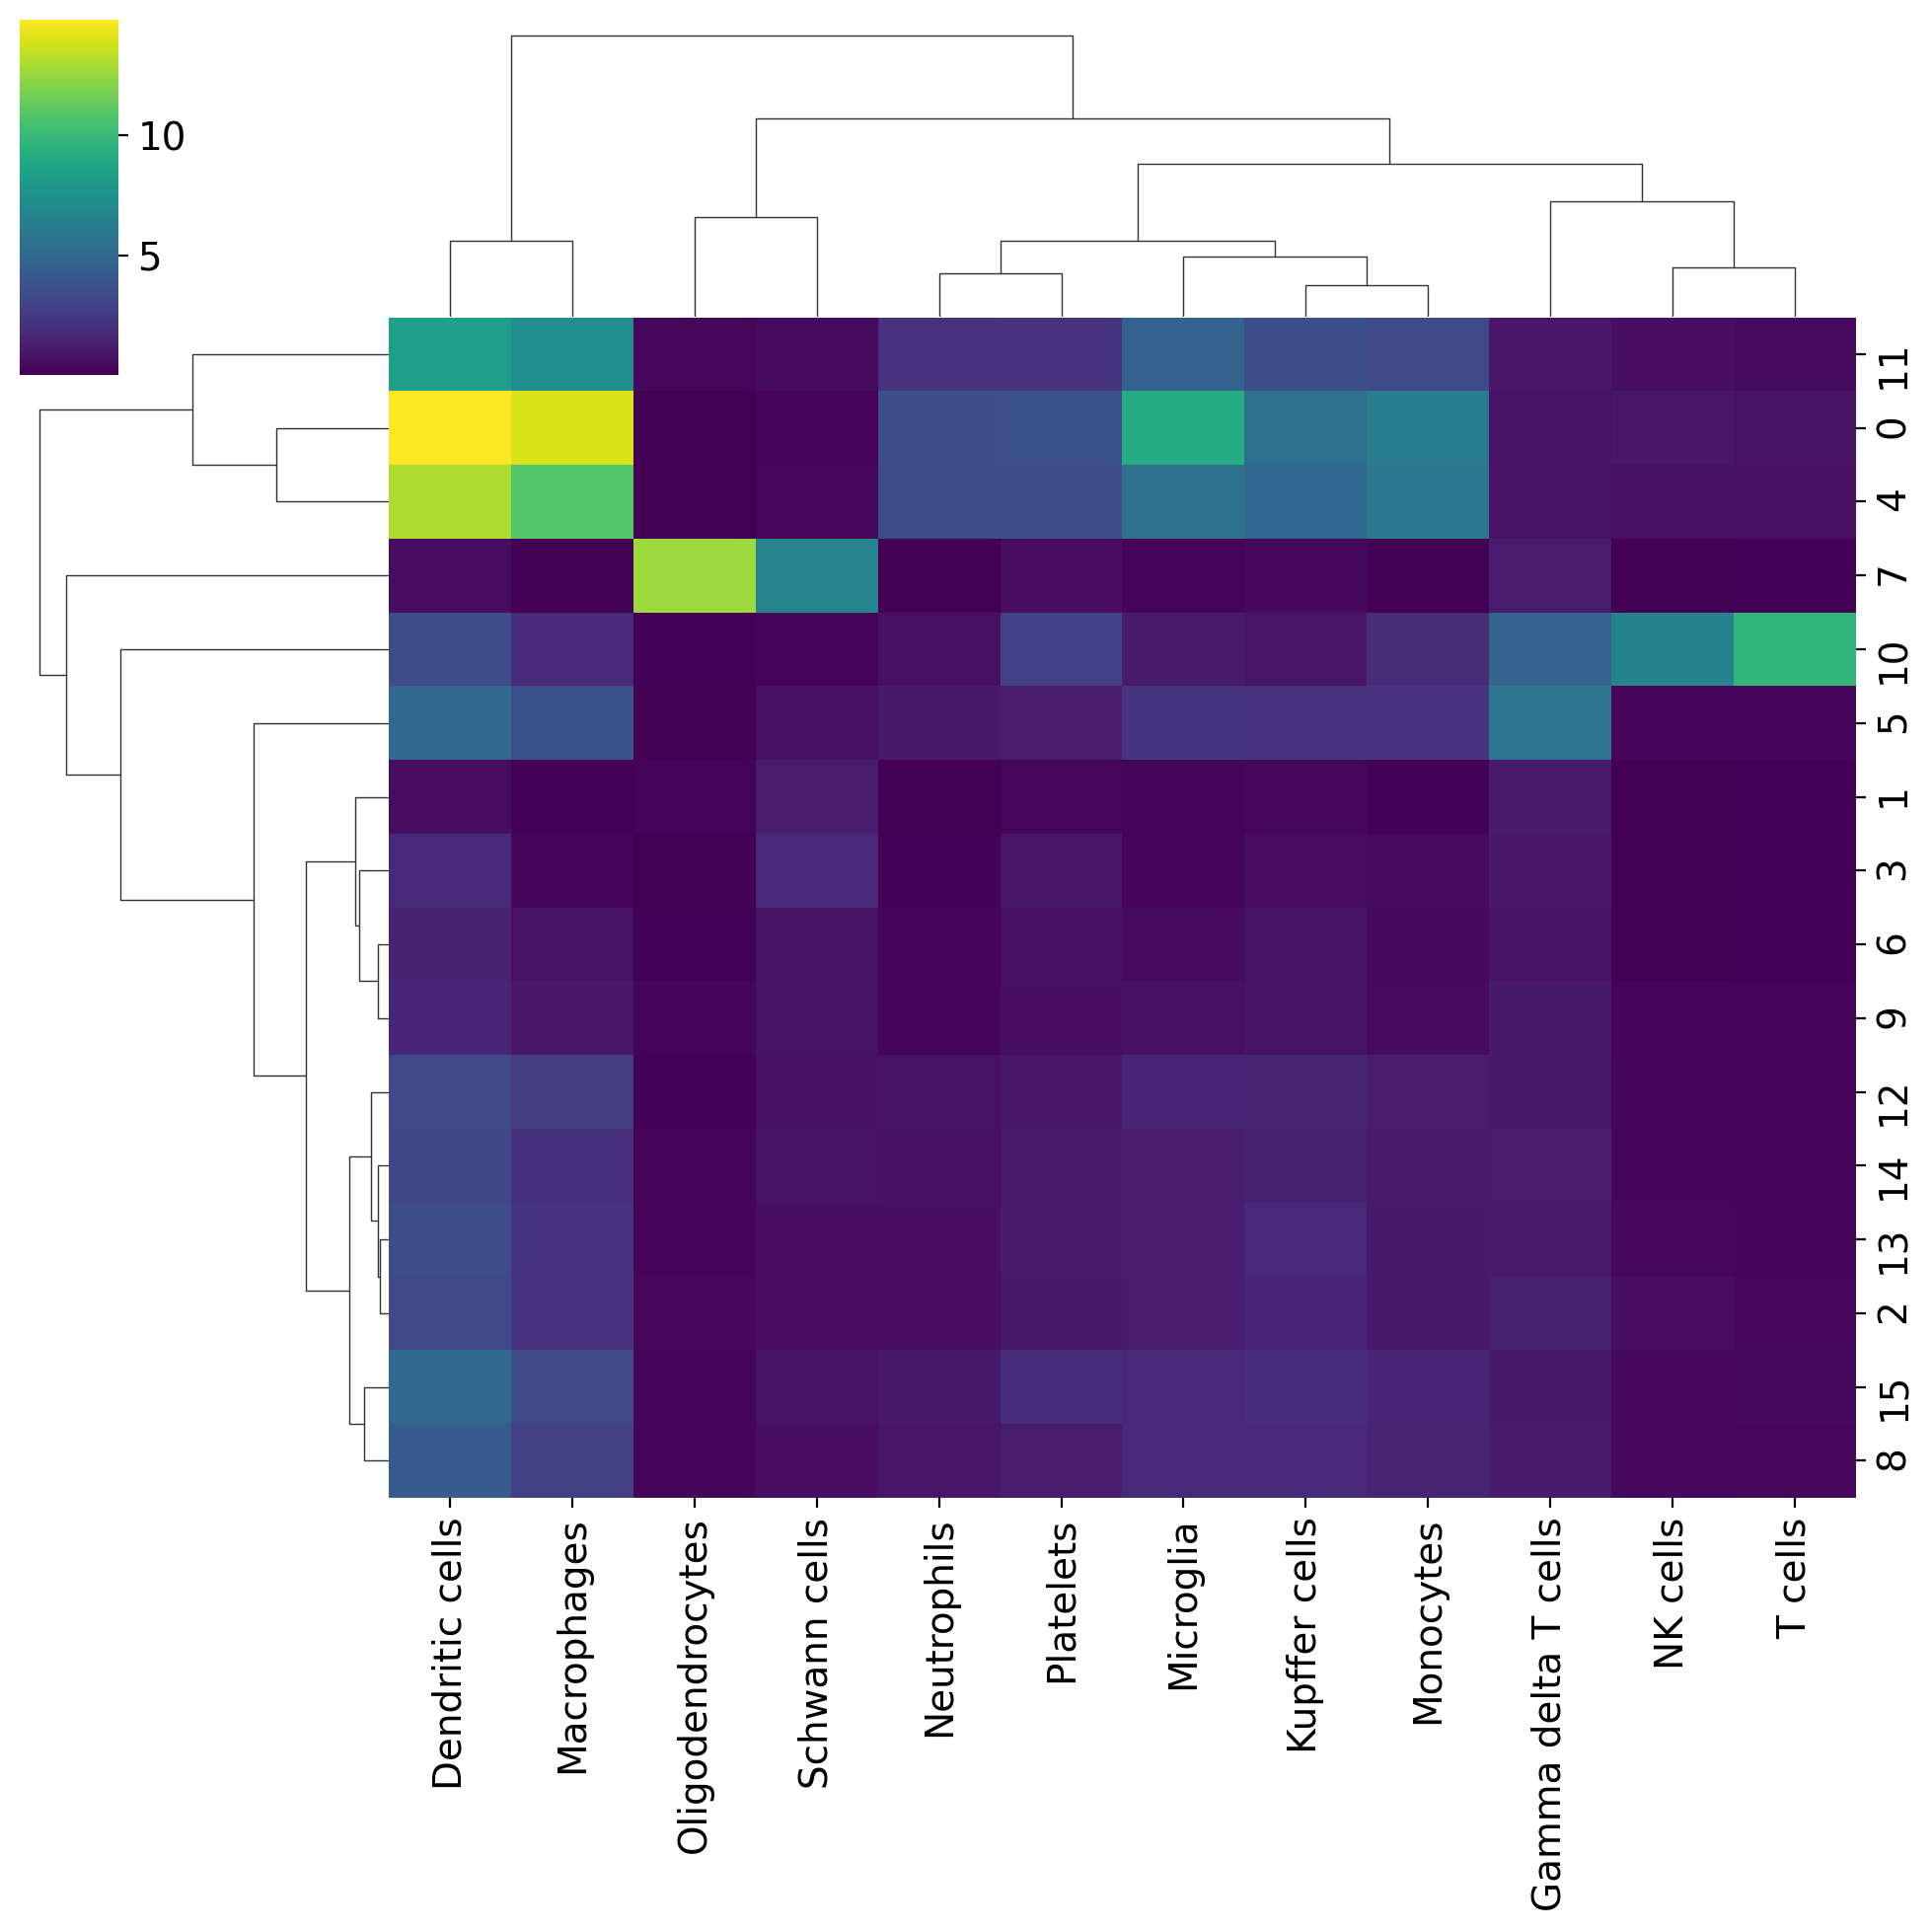

In [53]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [54]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'Dendritic cells',
 '1': 'Schwann cells',
 '10': 'T cells',
 '11': 'Dendritic cells',
 '12': 'Dendritic cells',
 '13': 'Dendritic cells',
 '14': 'Dendritic cells',
 '15': 'Dendritic cells',
 '2': 'Dendritic cells',
 '3': 'Dendritic cells',
 '4': 'Dendritic cells',
 '5': 'Gamma delta T cells',
 '6': 'Dendritic cells',
 '7': 'Oligodendrocytes',
 '8': 'Dendritic cells',
 '9': 'Dendritic cells'}

... storing 'cell_type' as categorical


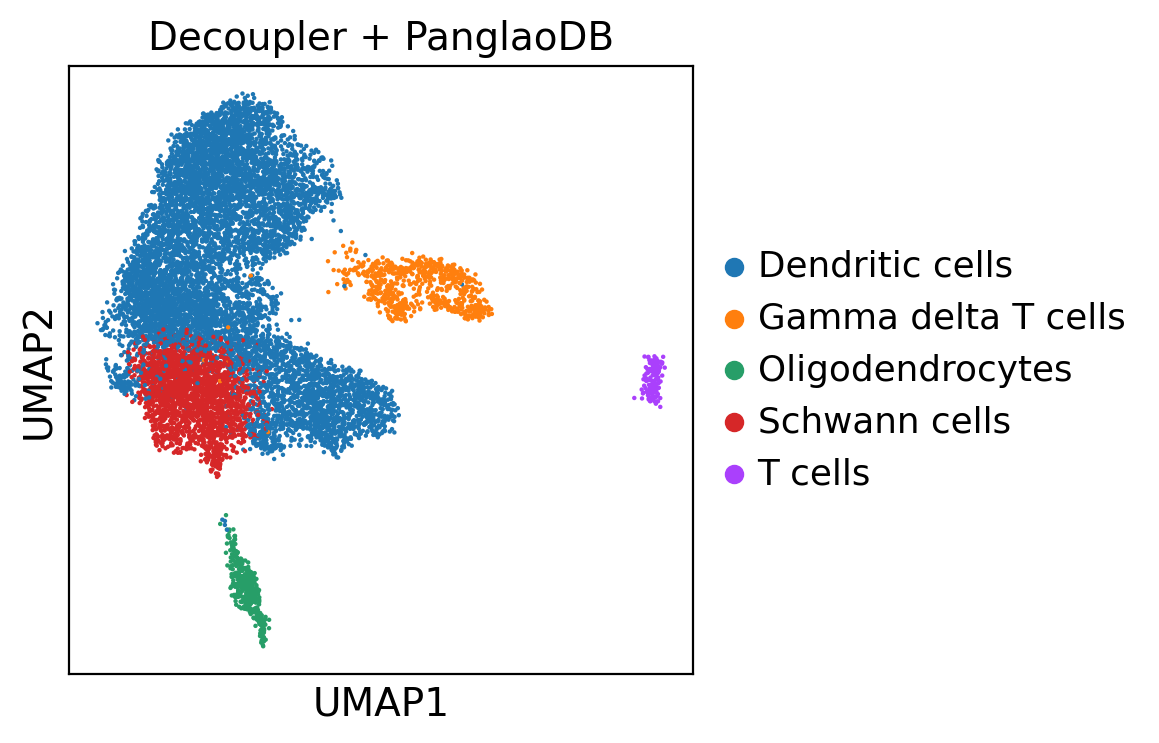

In [55]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [56]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_B_GSE131928_PMID31327527.h5ad")